## Домашнее задание №1: Полносвязные нейронные сети

### Пожалуйста, заполните имя

In [1]:
STUDENT_NAME = "Liubov Antiufrieva" # For example, Fedor Petriaikin

In [2]:
# Включает режим проверки
from importlib import reload

try:
    import test_lib
    TEST_MODE = True
except:
    TEST_MODE = False

In [3]:
import numpy as np
import matplotlib.pyplot as plt

**Не удаляйте клетки из этого jupyter-notebok! Это затруднит проверку!**

В этом задании вам предстоит самостоятельно самостоятельно реализовать простую полносвязную нейронную сеть, процедуру обучения. Правильность нашей реализации мы проверим на примере задачи распознавания рукописных цифр (датасет MNIST).

Каждый тип слоя мы будем реализовывать при помощи класса, который будет поддерживать три функции:
1. forward(X) - применяет функцию, реализуемую слоем, к входной матрице (X), X.shape = N x features_size, N - размер батча
2. backward(dLdy) - которая по $\frac{\partial L}{\partial y}$ будет вычислять $\frac{\partial L}{\partial x}$ и обновлять внутри себя $\frac{\partial L}{\partial w}$, dLdy.shape - N x 1 = градиент по каждому из объектов батча
3. step(learning_rate), которая будет обновлять веса в слое

Чтобы не применять функцию к каждому объекту в отдельности, мы будем подавать на вход слою матрицу размера (N, d), где N — количество объектов (размер batch-а), а d (то же, что и input_size, features_count) — размерность каждого объекта.

### Задание 1
**Требуется реализовать слои (в layers.py):**  
1. Linear. В инициализацию весов следует сделать из N(0, 0.01)
2. Sigmoid, ReLU, ELU, Tanh - нелинейности
3. SoftMax_NLLLoss. Обратите внимание, что это особый слой - он совмещает в себе и слой-предиктор, и функцию ошибок. Это нужно, чтобы упросить расчет градиента с помощью трюка log-sum-exp (позволяет избежать численных неустойчивостей):  
https://ljvmiranda921.github.io/notebook/2017/08/13/softmax-and-the-negative-log-likelihood/
4. MSE_Error - loss-функция, считает dL/dy для запуска backprop.
5. NeuralNetwork - класс, объединяющий слои

**Обратите внимание**
1. Изменять интерфейс классов в layers.py **не следует**, т.к. иначе тестирующий код не сможет выполниться
2. Важным требованием к реализации является векторизация всех слоев: **все операции должны быть сведены к матричным**, не должно быть циклов. Это значительно уменьшает временные затраты.
3. Отличная визуализация работы полносвязных нейронных сетей: http://playground.tensorflow.org/

### Проверка задания 1
Нужно написать свой код для проверки и пройти тесты кода, который не предоставляется

In [4]:
import layers

**Проверка 1 - численный градиент**

1. Релизуйте функцию проверки численного градиента. Для этого для каждой переменной, по которой считается градиент, надо вычислить численный градиент: $f'(x) \approx \frac{f(x+\epsilon)-f(x-\epsilon)}{2\epsilon}$. Функция должна возвращать максимальное абсолютное отклонение аналитического градиента от численного. В качестве $\epsilon$ рекомендуется взять $10^{-6}$. При правильной реализации максимальное отличие будет иметь порядок $10^{-8}-10^{-6}$.

2. Протестируйте линейный слой при помощи реализованной функции check_gradient: $\frac{\partial L}{\partial x}$ и $\frac{\partial L}{\partial w}$.

3. По аналогии, протестируйте SoftMax_NLLLoss

In [5]:
# 1.
def check_gradient(func, X, gradient):
    '''
    Computes numerical gradient and compares it with analytcal.
    func: callable, function of which gradient we are interested. Example call: func(X)
    X: np.array of size (n x m)
    gradient: np.array of size (n x m)
    Returns: maximum absolute diviation between numerical gradient and analytical.
    '''
    #### YOUR CODE HERE
    epsilon = 10**(-6)
    numerical_gradient = (func(X+epsilon)- func(X-epsilon))/(2*epsilon)
    dif = numerical_gradient - gradient.sum()
    dif = np.absolute(dif)
    return dif


# 2. Проверка слоя Linear
lin = layers.Linear(10, 2)
X = np.ones((5, 10))
y = lin.forward(X)

func = lambda x: lin.forward(x).sum() # Аналог функции ошибок
dLdy = np.ones((5, 2)) # Очевидно, что производная суммы по всем y = 1
gradient = lin.backward(dLdy)
print("Check grad linear: {}".format(check_gradient(func, X, gradient)))

#3. Проверка SoftMax_NLLLoss
#### YOUR CODE HERE
Loss= layers.SoftMax_NLLLoss()
X = np.ones((10, 3))
y = Loss.forward(X)

func = lambda x: Loss.forward(x).sum() # Аналог функции ошибок
dLdy = np.ones((10,1)).astype(int)+1 # Второй класс

gradient = Loss.backward(dLdy)
print("Check grad SoftMax_NLLLoss: {}".format(check_gradient(func, X, gradient)))

Check grad linear: 5.752287535187861e-12
Check grad SoftMax_NLLLoss: 1.1102230246251565e-15


In [6]:
# Проверка вашей реализации check_gradient и Linear
# Не изменяйте эти ячейки!
if TEST_MODE:
    try:
        test_lib.test_grad_checker(test_lib.check_gradient)
        test_lib.check_grads(layers.Linear, layers.Sigmoid, layers.SoftMax_NLLLoss, layers.Tanh)
    except Exception as e:
        print("!!>> Tasks grad_check failed:")
        raise e

**Проверка 2**  
Следующий код должен выполниться и дать корректную классификацию объектов. Это нужно, чтобы проверить интерфейс классов из layers

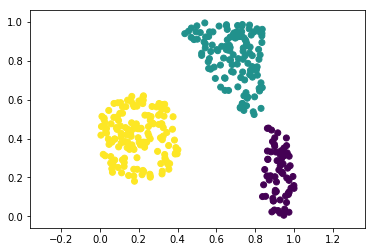

In [7]:
data = np.load('data.npz')
X, y = data['arr_0'], data['arr_1']
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.axis('equal')
plt.show()

In [8]:
arc = [layers.Linear(2, 3), layers.Sigmoid(), layers.Linear(3, 3), layers.SoftMax_NLLLoss()]
#print (arc)
network = layers.NeuralNetwork(arc)

def learn_network(network, X, y, learning_rate=5, iterations=16000):
    for i in range(iterations):
        prediction = network.forward(X)
        network.backward(y)
        network.step(learning_rate)
# print (y)
learn_network(network, X, y)

In [9]:
def plot_mesh_with_scatter(X, y, pred_func, N=50, additional=0.15):
    '''
    pred_func(mesh) - returns classes from mesh grid
    '''
    delta_x = (np.max(X[:, 0])-np.min(X[:, 0]))*additional
    delta_y = (np.max(X[:, 1])-np.min(X[:, 1]))*additional
    
    x_grid = np.linspace(np.min(X[:, 0])-delta_x, np.max(X[:, 0])+delta_x, N)
    y_grid = np.linspace(np.min(X[:, 1])-delta_y, np.max(X[:, 1])+delta_y, N)
    X_mesh, Y_mesh = np.meshgrid(x_grid, y_grid)
    mesh = np.dstack((X_mesh, Y_mesh)).reshape(N*N, 2)
    
    predictions = pred_func(mesh)
    
    plt.scatter(mesh[:, 0], mesh[:, 1], c=predictions, alpha=0.2)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.axis('equal')
    plt.show()

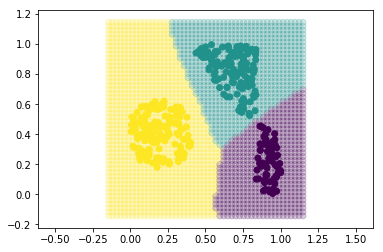

In [10]:
#print(y.size)
plot_mesh_with_scatter(X, y, lambda x: np.argmax(network.forward(x), 1))

### Задание 2
1. Попробуйте разные темпы обучения (6-7 значений в пределах 0.01 - 20, с логарифмическим масштабом).  
Как меняется сходимость и почему? Нарисуйте график оптимального значения функции потерь для различных значений learning_rate (для этого реализуйте в нейронной сети и ее слоях функцию get_loss)
2. Решите поставленную выше задачу как задачу регрессии с MSE. Изменилась ли разделяющая поверхность? Нарисуйте ее, с помощью plot_mesh_with_scatter.

**На это задание нет специальных тестов, оно проверяется вручную**

In [11]:
### YOUR CODE HERE
learning_rate_mas = np.geomspace(0.01, 20, num=7)
loss = np.zeros(7)
for i in range (learning_rate_mas.size):
    arc = [layers.Linear(2, 3), layers.Sigmoid(), layers.Linear(3, 3), layers.SoftMax_NLLLoss()]
    network = layers.NeuralNetwork(arc)
    learn_network(network, X, y, learning_rate=learning_rate_mas[i])
    loss[i] = network.get_loss(y,3)
    print ('lr:', learning_rate_mas[i], 'Loss:', loss[i])

lr: 0.01 Loss: 1.087756110109005
lr: 0.035495366597555714 Loss: 0.10489387212744829
lr: 0.12599210498948735 Loss: 0.10618554037292464
lr: 0.447213595499958 Loss: 0.0029526484624501402
lr: 1.5874010519682002 Loss: 0.0008841546949808223
lr: 5.6345382276956855 Loss: 0.00020834155898352563
lr: 20.000000000000004 Loss: 1.9122504416982844


Text(0, 0.5, 'Loss')

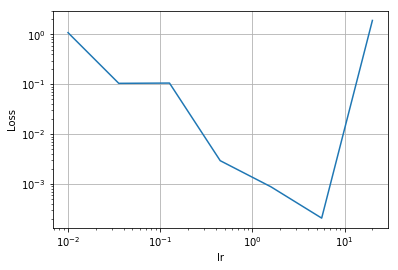

In [12]:
plt.plot(learning_rate_mas, loss)
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.xlabel('lr')
plt.ylabel('Loss')

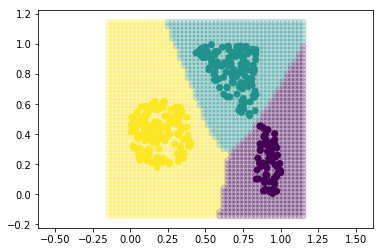

In [13]:
arc = [layers.Linear(2, 3), layers.Sigmoid(), layers.Linear(3, 3), layers.MSE_Error()]
network = layers.NeuralNetwork(arc)
learn_network(network, X, y,learning_rate=0.2)
plot_mesh_with_scatter(X, y, lambda x: np.argmax(network.forward(x), 1))

### Распознование рукописных цифр
Ниже приведен код для загрузки датасета и визуализация нескольких объектов из него

In [14]:
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

In [15]:
# Не изменяйте имена в этой ячейке! Они нужны для тестов
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)) # Нормализация данных
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

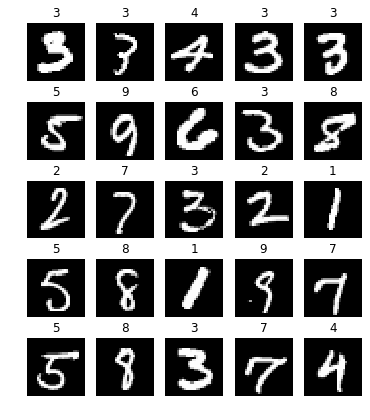

In [16]:
for X, y in train_loader:
    X = X.view(X.shape[0], -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()

plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Задание 3
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности (объект создан ниже).  
Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.4. Число эпох выберете по своему усмотрению.

**Обратите внимание**  
1. Итерироваться по данным можно с помощью выражения *for X, y in some_loader* При этом X, y - будут иметь тип torch.Tensor. Чтобы конвертировать их в numpy-массивы нужно вызвать функцию .numpy()
2. Каждый объект из X имеет размерность 1x28x28. Поэтому перед .numpy() нужно вызвать *X = X.view(X.shape[0], -1)*, чтобы получить одномерный массив
3. Качество на тесте (масксимальное среди эпох) должно быть не хуже **0.972**

In [17]:
learning_rate = 0.4

In [18]:
def numb_true(p, y):
    class_numb = np.argmax(p, 1)
    return np.sum(class_numb==y)

In [19]:
def train_nn(network, epochs, learning_rate, train=train_loader, test=test_loader):
    Loss_train = np.zeros(epochs)
    Loss_test =  np.zeros(epochs)
    ### YOUR CODE HERE
    for i in range(epochs):
        print ('epoch:', i)
        # Учим
        Loss = 0
        n = 0
        numb_tr = 0
        numb_el = 0
        # Достаем батчи 
        for X, y in train:
            X = X.view(X.shape[0], -1)
            X = X.numpy() ### Converts torch.Tensor to numpy array
            y = y.numpy()
            prediction = network.forward(X)
            Loss = Loss + network.get_loss(y,10)
            network.backward(y)
            network.step(learning_rate)
            n = n+1
            numb_tr = numb_tr+numb_true(prediction, y)
            numb_el = numb_el+y.size
        Loss_train[i] = Loss/n
        print ('Train Loss:', Loss/n)
        print ('accuracy_train:', numb_tr/numb_el)
        # Прверяем
        Loss = 0
        n = 0
        numb_tr = 0
        numb_el = 0
        for X, y in test:
            X = X.view(X.shape[0], -1)
            X = X.numpy() ### Converts torch.Tensor to numpy array
            y = y.numpy()
            prediction = network.forward(X)
            Loss = Loss + network.get_loss(y, 10)
            n = n+1
            numb_tr = numb_tr+numb_true(prediction, y)
            numb_el = numb_el+y.size
        Loss_test[i] = Loss/n
        print ('Test Loss:', Loss/n)
        print ('accuracy_test:', numb_tr/numb_el)
    plt.plot(range(1,epochs+1), Loss_train, range(1,epochs+1), Loss_test)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.ylabel('Loss')

epoch: 0
Train Loss: 1.5968722843420842
accuracy_train: 0.61695
Test Loss: 0.3853649942216607
accuracy_test: 0.9363
epoch: 1
Train Loss: 0.31420095559116756
accuracy_train: 0.9461833333333334
Test Loss: 0.2546881456650932
accuracy_test: 0.956
epoch: 2
Train Loss: 0.2031696187703554
accuracy_train: 0.9647666666666667
Test Loss: 0.19471816769728462
accuracy_test: 0.9661
epoch: 3
Train Loss: 0.15637030793365048
accuracy_train: 0.97375
Test Loss: 0.20273272660484914
accuracy_test: 0.9654
epoch: 4
Train Loss: 0.12294283827921612
accuracy_train: 0.97905
Test Loss: 0.17018360438119687
accuracy_test: 0.9698
epoch: 5
Train Loss: 0.10919847026555185
accuracy_train: 0.98085
Test Loss: 0.17656275001862326
accuracy_test: 0.9679
epoch: 6
Train Loss: 0.08674480165487185
accuracy_train: 0.9852
Test Loss: 0.16136917146765328
accuracy_test: 0.9723
epoch: 7
Train Loss: 0.07351206197171012
accuracy_train: 0.98775
Test Loss: 0.16849028761546472
accuracy_test: 0.9715
epoch: 8
Train Loss: 0.05899146710324429

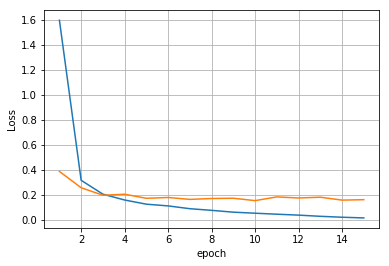

In [20]:
if not TEST_MODE:
    epochs_count = 15 # Введите сюда число эпох

    neural_network = layers.NeuralNetwork([layers.Linear(784, 100), layers.Sigmoid(), layers.Linear(100, 100), 
                                           layers.Sigmoid(), layers.Linear(100, 10), layers.SoftMax_NLLLoss()])
    train_nn(neural_network, epochs_count, learning_rate)

### Проверка задания 3

In [21]:
# Проверка качества нейронной сети
if TEST_MODE:
    test_lib.train_task3(learning_rate, train_loader, test_loader)

### Задание 4
Обучите нейронную сеть как в задании 3, но используйте в качестве нелинейности ELU и ReLU. Качество должно быть не менее **0.977** в каждом случае (можно подбирать learning_rate, число эпох, коэффициенты в ELU/ReLU)

In [ ]:
# Подбирайте параметры с помощью этих параметров
learning_rate_elu  = 0.008
learning_rate_relu = 0.008

epochs_elu = 25
epochs_relu = 25

a_elu = 0.2
a_relu = 0.1

In [ ]:
if not TEST_MODE:
    #ELU
    neural_network_elu = layers.NeuralNetwork([layers.Linear(784, 100), layers.ELU(a_elu), layers.Linear(100, 100), 
                                           layers.ELU(a_elu), layers.Linear(100, 10), layers.SoftMax_NLLLoss()])
    train_nn(neural_network_elu, epochs_elu, learning_rate_elu)

In [ ]:
if not TEST_MODE:
    # ReLU
    neural_network_ReLU = layers.NeuralNetwork([layers.Linear(784, 100), layers.ReLU(a_relu), layers.Linear(100, 100), 
                                           layers.ReLU(a_relu), layers.Linear(100, 10), layers.SoftMax_NLLLoss()])
    train_nn(neural_network_ReLU, epochs_relu, learning_rate_relu)

### Проверка задания 4

In [33]:
# Проверка качества нейронной сети (ELU)
if TEST_MODE:
    test_lib.train_task4_elu(a_elu, learning_rate_elu, epochs_elu, train_loader, test_loader)

In [34]:
# Проверка качества нейронной сети (ReLU)
if TEST_MODE:
    test_lib.train_task4_relu(a_relu, learning_rate_relu, epochs_relu, train_loader, test_loader)

### Задание 5
Примените аугментацию:
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности? Напишите вывод. Постарайтесь добиться максимального качества, не изменяя размерности слоев

In [ ]:
from scipy.ndimage.interpolation import shift, rotate

In [ ]:
# X - np.array, X.shape = batch_size x 1 x 28 x 28
def add_noise(X, noise_std):
    ### YOUR CODE HERE
    return X+np.random.normal(0, noise_std, X.shape)


def random_shift(X, max_shift):
     ### YOUR CODE HERE
    ans = np.zeros(X.shape)
    for i in range (X.shape[0]):
        delta_x = np.rint(2*max_shift*np.random.random()-max_shift)
        delta_y = np.rint(2*max_shift*np.random.random()-max_shift)
        ans[i][0] = shift(X[i][0],(delta_x,delta_y))
    return ans

def random_rotation(X, max_rot=15):
    ### YOUR CODE HERE
    ans = np.zeros(X.shape)
    for i in range (X.shape[0]):
        angle = 2*max_rot*np.random.random()-max_rot
        plt.imshow(rotate(X[i][0], angle), cmap=plt.cm.Greys_r)
        rot = rotate(X[i][0], angle)
        d = int((rot.shape[0]-ans.shape[2])/2)
        ans[i][0] = rot[d:d+ans.shape[2], d:d+ans.shape[2]]
    return ans

In [ ]:
# Исправьте функцию train, чтобы она принимала augmentations - массив функций f(x),
# которые производят преобразования-аугментации
# Воспользуйтесь X.numpy(), а потом ndarray.view() для сокращения числа размеростей
def train_nn_aug(network, epochs, learning_rate, augmentations, train=train_loader, test=test_loader):
    ### YOUR CODE HERE
    Loss_train = np.zeros(epochs)
    Loss_test =  np.zeros(epochs)
    ### YOUR CODE HERE
    for i in range(epochs):
        print ('epoch:', i)
        # Учим
        Loss = 0
        n = 0
        numb_tr = 0
        numb_el = 0
        # Достаем батчи 
        for X, y in train:
            # Аргументация
            X = X.numpy()### Converts torch.Tensor to numpy array
            for func in augmentations:
                X = func(X)
            X = X.reshape(X.shape[0], -1)
            y = y.numpy()
            prediction = network.forward(X)
            Loss = Loss + network.get_loss(y,10)
            network.backward(y)
            network.step(learning_rate)
            n = n+1
            numb_tr = numb_tr+numb_true(prediction, y)
            numb_el = numb_el+y.size
        Loss_train[i] = Loss/n
        print ('Train Loss:', Loss/n)
        print ('accuracy_train:', numb_tr/numb_el)
        # Прверяем
        Loss = 0
        n = 0
        numb_tr = 0
        numb_el = 0
        for X, y in test:
            X = X.view(X.shape[0], -1)
            X = X.numpy() ### Converts torch.Tensor to numpy array
            y = y.numpy()
            prediction = network.forward(X)
            Loss = Loss + network.get_loss(y, 10)
            n = n+1
            numb_tr = numb_tr+numb_true(prediction, y)
            numb_el = numb_el+y.size
        Loss_test[i] = Loss/n
        print ('Test Loss:', Loss/n)
        print ('accuracy_test:', numb_tr/numb_el)
    plt.plot(range(1,epochs+1), Loss_train, range(1,epochs+1), Loss_test)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.ylabel('Loss')

epoch: 0
Train Loss: 2.891072630794503
accuracy_train: 0.2446
Test Loss: 1.5859581567780843
accuracy_test: 0.7038
epoch: 1
Train Loss: 0.8895266720657907
accuracy_train: 0.8489333333333333
Test Loss: 0.5597502221381675
accuracy_test: 0.9088
epoch: 2
Train Loss: 0.4533938737009254
accuracy_train: 0.9258666666666666
Test Loss: 0.3566360548854928
accuracy_test: 0.943
epoch: 3
Train Loss: 0.3143355324982059
accuracy_train: 0.9489666666666666
Test Loss: 0.27134888124967954
accuracy_test: 0.9571
epoch: 4
Train Loss: 0.2473532998003819
accuracy_train: 0.9595666666666667
Test Loss: 0.23270679611824752
accuracy_test: 0.9633
epoch: 5
Train Loss: 0.20446138505670533
accuracy_train: 0.9673
Test Loss: 0.20516860340993126
accuracy_test: 0.9668
epoch: 6
Train Loss: 0.17467056567043157
accuracy_train: 0.9720833333333333
Test Loss: 0.18753758234047377
accuracy_test: 0.9686
epoch: 7
Train Loss: 0.15365580012348903
accuracy_train: 0.9754333333333334
Test Loss: 0.16982594789795263
accuracy_test: 0.9708
ep

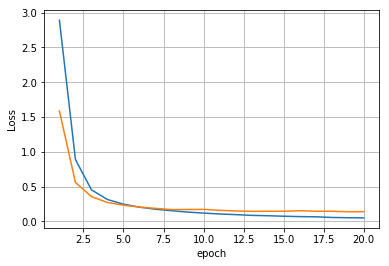

In [ ]:
# Проанализируйте различные аугментации

### YOUR CODE HERE
# Шум
network = layers.NeuralNetwork([layers.Linear(784, 100), layers.Sigmoid(), layers.Linear(100, 100), 
                                           layers.Sigmoid(), layers.Linear(100, 10), layers.SoftMax_NLLLoss()])
epochs = 20
noise_std = 0.3
learning_rate = 0.1
train_nn_aug(network, epochs, learning_rate, [lambda x: add_noise(x, noise_std)])

epoch: 0
Train Loss: 3.1536157750115783
accuracy_train: 0.15466666666666667
Test Loss: 2.4968820511309833
accuracy_test: 0.3805
epoch: 1
Train Loss: 1.7098999008890108
accuracy_train: 0.63855
Test Loss: 0.8503756405835138
accuracy_test: 0.8713
epoch: 2
Train Loss: 0.8551473364755597
accuracy_train: 0.8545166666666667
Test Loss: 0.4566269383359816
accuracy_test: 0.9319
epoch: 3
Train Loss: 0.541845666053691
accuracy_train: 0.9096833333333333
Test Loss: 0.3188567548777317
accuracy_test: 0.9522
epoch: 4
Train Loss: 0.4099131631307154
accuracy_train: 0.9310666666666667
Test Loss: 0.26014192245415885
accuracy_test: 0.9593
epoch: 5
Train Loss: 0.3434711907520155
accuracy_train: 0.9426333333333333
Test Loss: 0.21287797549610762
accuracy_test: 0.9684
epoch: 6
Train Loss: 0.3098295573938379
accuracy_train: 0.9464333333333333
Test Loss: 0.20063049024226406
accuracy_test: 0.9676
epoch: 7
Train Loss: 0.27634141642603677
accuracy_train: 0.9533333333333334
Test Loss: 0.1910176203783646
accuracy_test

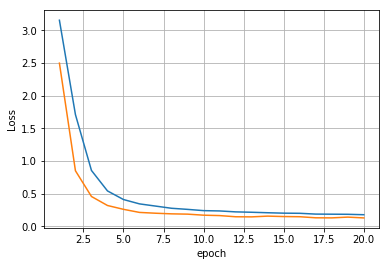

In [ ]:
# Сдвиг
network = layers.NeuralNetwork([layers.Linear(784, 100), layers.Sigmoid(), layers.Linear(100, 100), 
                                           layers.Sigmoid(), layers.Linear(100, 10), layers.SoftMax_NLLLoss()])
epochs = 20
max_shift = 2
train_nn_aug(network, epochs, learning_rate, [lambda x: random_shift(x, max_shift)])

In [ ]:
# Поворот
network = layers.NeuralNetwork([layers.Linear(784, 100), layers.Sigmoid(), layers.Linear(100, 100), 
                                           layers.Sigmoid(), layers.Linear(100, 10), layers.SoftMax_NLLLoss()])
epochs = 20
train_nn_aug(network, epochs, learning_rate, [lambda x: random_rotation(x)])

In [ ]:
# Все включено
network = layers.NeuralNetwork([layers.Linear(784, 100), layers.Sigmoid(), layers.Linear(100, 100), 
                                           layers.Sigmoid(), layers.Linear(100, 10), layers.SoftMax_NLLLoss()])
epochs = 30
train_nn_aug(network, epochs, learning_rate, [lambda x: add_noise(x, noise_std), lambda x: random_shift(x, max_shift), lambda x: random_rotation(x)])

In [ ]:
# В этих функциях нужно создать нейронную сеть и массив функций-аугментаторов, которые дают наилучший скор
#========================================================================================================
# Не успела перебрать достаточное колличество вариантов
#========================================================================================================

def create_best_nn():
    network = layers.NeuralNetwork([layers.Linear(784, 100), layers.Sigmoid(), layers.Linear(100, 100), 
                                           layers.Sigmoid(), layers.Linear(100, 10), layers.SoftMax_NLLLoss()])
    return network

def create_best_augmentations():
    noise_std = 0.3
    max_shift = 2
    arg = [lambda x: add_noise(x, noise_std), lambda x: random_shift(x, max_shift), lambda x: random_rotation(x)]
    return arg

# Здесь же можно задать learning_rate и число эпох
learning_rate = 0.1
epochs_count = 30

### Проверка задания 5

In [ ]:
# Проверка качества нейронной сети
if TEST_MODE:
    test_lib.train_task5(create_best_nn, create_best_augmentations, learning_rate, epochs_count,
                         train_loader, test_loader)

Спасибо за выполнение заданий!